# Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
import bisect
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,KFold

import pickle


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_tabnet.tab_model import TabNetRegressor

# Data Load

In [3]:
train = pd.read_csv('../new_open/train_merge.csv')#.drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../new_open/test_merge.csv')#.drop(columns=['SAMPLE_ID'])

# Pretrain

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
RANDOM_STATE = 4158

In [5]:
X_train = train.drop('CI_HOUR', axis=1)
#X_train = X_train[importance_features]
#test = test[importance_features]
y_train = train['CI_HOUR']

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=RANDOM_STATE)

In [6]:
## constant values for hyper-parameter
BATCH_SIZE = 2**11
GHOST_BATCH = 2**7
# N_D = N_A = 12
MAX_EPOCH = 100
# MASK_TYPE = "entmax"
N_STEPS = 5
LR = 0.001
PATIENCE = 8
# PRETRAINING_RATIO = 0.7
NROWS = 1

In [7]:
tabnet_params = dict(
    #cat_idxs=cat_idxs,
    #cat_dims=cat_dims,
    optimizer_fn=torch.optim.Adam,
    seed=RANDOM_STATE,
    optimizer_params=dict(lr=LR), 
    # scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    # scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device_name=str(DEVICE)
)

pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
    X_train=X_train.values, eval_set=[X_val.values], 
    max_epochs=MAX_EPOCH, 
    patience=PATIENCE, 
    batch_size=BATCH_SIZE, 
    virtual_batch_size=GHOST_BATCH, 
    num_workers=0, 
    drop_last=False, 
    # pretraining_ratio=PRETRAINING_RATIO
)

epoch 0  | loss: 39335.8759| val_0_unsup_loss_numpy: 14568.576171875|  0:00:21s
epoch 1  | loss: 18108.54808| val_0_unsup_loss_numpy: 14026.701171875|  0:00:41s
epoch 2  | loss: 17859.33839| val_0_unsup_loss_numpy: 13913.0849609375|  0:01:00s
epoch 3  | loss: 17717.89012| val_0_unsup_loss_numpy: 13769.5517578125|  0:01:20s
epoch 4  | loss: 17395.49401| val_0_unsup_loss_numpy: 13685.7080078125|  0:01:40s
epoch 5  | loss: 17004.73551| val_0_unsup_loss_numpy: 13705.2822265625|  0:02:00s
epoch 6  | loss: 16585.46935| val_0_unsup_loss_numpy: 13649.5498046875|  0:02:20s
epoch 7  | loss: 16117.59568| val_0_unsup_loss_numpy: 13704.517578125|  0:02:39s
epoch 8  | loss: 15633.10073| val_0_unsup_loss_numpy: 13748.140625|  0:02:59s
epoch 9  | loss: 14966.13221| val_0_unsup_loss_numpy: 13760.7509765625|  0:03:19s
epoch 10 | loss: 14464.12618| val_0_unsup_loss_numpy: 13760.892578125|  0:03:38s
epoch 11 | loss: 14103.14414| val_0_unsup_loss_numpy: 13774.2724609375|  0:03:59s
epoch 12 | loss: 13648.73

In [8]:
pretrain_explain_matrix, pretrain_masks = pretrainer.explain(X_val.values)

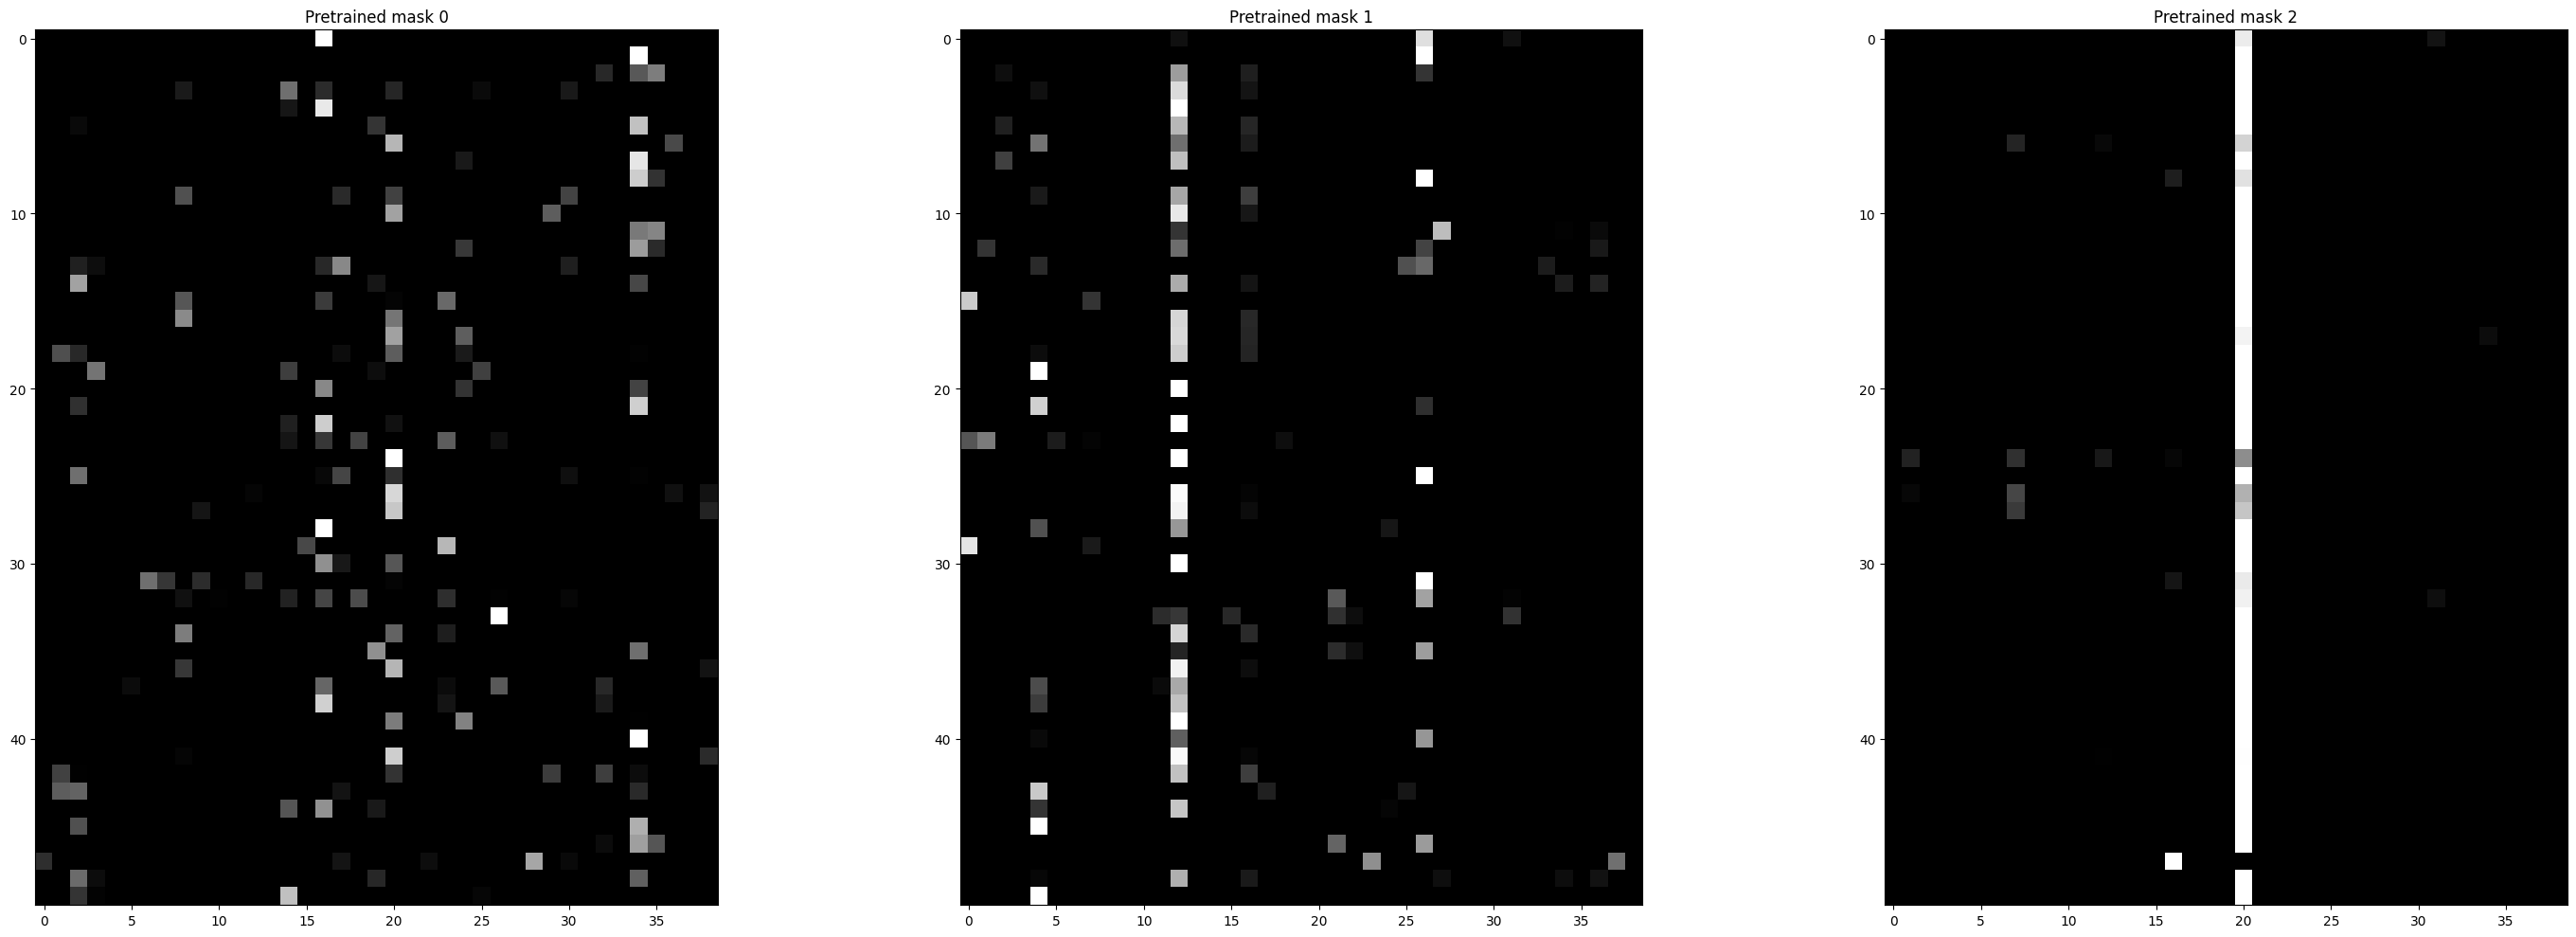

In [9]:
plt.figure(figsize=(30, 10))
for key in pretrain_masks:
    plt.subplot(int(f"{NROWS}{len(pretrain_masks)//NROWS}{key+1}"))
    plt.imshow(pretrain_masks[key][:50], cmap='gray')
    # plt.axis('off')
    plt.title(f"Pretrained mask {key}")
plt.tight_layout()
plt.show()

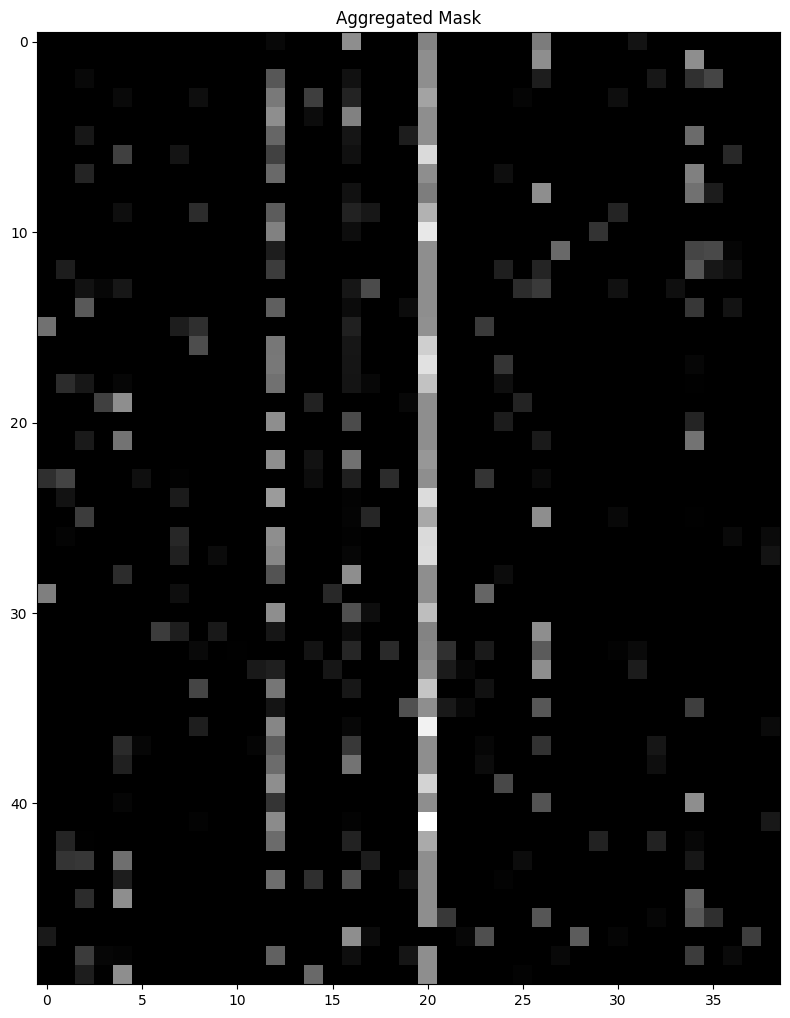

In [10]:
mask_agg = np.zeros(shape=pretrain_masks[0].shape)
for key in pretrain_masks:
    mask_agg += pretrain_masks[key]
mask_agg /= len(pretrain_masks)

plt.figure(figsize=(8, 12))
plt.imshow(mask_agg[:50], cmap='gray')
plt.title(f"Aggregated Mask")
# plt.axis('off')
plt.tight_layout()
plt.show()

# Regressor

In [11]:
reg = TabNetRegressor(
    #cat_idxs=cat_idxs,
    #cat_dims=cat_dims,
    seed=RANDOM_STATE,
    optimizer_params=dict(lr=LR), 
    # scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    # scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device_name=str(DEVICE)
)

In [12]:
# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []
%time
for train_idx, val_idx in tqdm(kf.split(X_train), total=5, desc="Processing folds"):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    reg.fit(X_train=X_t.values, 
            y_train=y_t.values.reshape(-1, 1), eval_set=[(X_val.values, y_val.values.reshape(-1, 1))],
            max_epochs=MAX_EPOCH, 
            batch_size=BATCH_SIZE, 
            virtual_batch_size=GHOST_BATCH,
            patience=8,
            num_workers=0, 
            drop_last=False,
            from_unsupervised=pretrainer,
            eval_metric=['mae'])
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = reg.predict(X_val.values)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val.values, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = reg.predict(test.values)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

CPU times: total: 0 ns
Wall time: 0 ns


Processing folds:   0%|                                                                          | 0/5 [00:00<?, ?it/s]

epoch 0  | loss: 32986.67663| val_0_mae: 60.2608 |  0:00:13s
epoch 1  | loss: 32449.10406| val_0_mae: 59.93679|  0:00:26s
epoch 2  | loss: 31903.25935| val_0_mae: 59.80838|  0:00:40s
epoch 3  | loss: 31288.58501| val_0_mae: 59.83626|  0:00:53s
epoch 4  | loss: 30603.65554| val_0_mae: 60.22835|  0:01:06s
epoch 5  | loss: 29884.14721| val_0_mae: 61.09964|  0:01:20s
epoch 6  | loss: 29185.34918| val_0_mae: 62.24623|  0:01:33s
epoch 7  | loss: 28500.08081| val_0_mae: 63.74938|  0:01:46s
epoch 8  | loss: 27935.3963| val_0_mae: 64.81681|  0:02:00s
epoch 9  | loss: 27502.73053| val_0_mae: 66.19564|  0:02:13s
epoch 10 | loss: 27151.53795| val_0_mae: 66.73406|  0:02:27s

Early stopping occurred at epoch 10 with best_epoch = 2 and best_val_0_mae = 59.80838


Processing folds:  20%|█████████████                                                    | 1/5 [02:44<10:57, 164.46s/it]

epoch 0  | loss: 32461.62077| val_0_mae: 61.63234|  0:00:13s
epoch 1  | loss: 31924.63021| val_0_mae: 61.24467|  0:00:26s
epoch 2  | loss: 31363.47595| val_0_mae: 61.03353|  0:00:40s
epoch 3  | loss: 30741.1762| val_0_mae: 61.06845|  0:00:53s
epoch 4  | loss: 30042.93882| val_0_mae: 61.38963|  0:01:06s
epoch 5  | loss: 29296.88976| val_0_mae: 61.74063|  0:01:20s
epoch 6  | loss: 28564.94673| val_0_mae: 62.49789|  0:01:33s
epoch 7  | loss: 27922.72431| val_0_mae: 64.01979|  0:01:47s
epoch 8  | loss: 27382.24561| val_0_mae: 65.32318|  0:02:00s
epoch 9  | loss: 26885.14345| val_0_mae: 66.15895|  0:02:14s
epoch 10 | loss: 26531.91725| val_0_mae: 66.50804|  0:02:27s

Early stopping occurred at epoch 10 with best_epoch = 2 and best_val_0_mae = 61.03353


Processing folds:  40%|██████████████████████████                                       | 2/5 [05:29<08:13, 164.62s/it]

epoch 0  | loss: 32421.76945| val_0_mae: 61.88178|  0:00:13s
epoch 1  | loss: 31890.61572| val_0_mae: 61.5767 |  0:00:27s
epoch 2  | loss: 31347.53903| val_0_mae: 61.39802|  0:00:40s
epoch 3  | loss: 30713.79746| val_0_mae: 61.38086|  0:00:53s
epoch 4  | loss: 30037.03045| val_0_mae: 61.49814|  0:01:07s
epoch 5  | loss: 29325.56511| val_0_mae: 61.75934|  0:01:20s
epoch 6  | loss: 28604.84879| val_0_mae: 62.82371|  0:01:33s
epoch 7  | loss: 27962.36836| val_0_mae: 64.0129 |  0:01:47s
epoch 8  | loss: 27379.64944| val_0_mae: 65.25942|  0:02:00s
epoch 9  | loss: 26885.04752| val_0_mae: 66.37287|  0:02:13s
epoch 10 | loss: 26549.68766| val_0_mae: 66.77254|  0:02:27s
epoch 11 | loss: 26278.96952| val_0_mae: 67.02619|  0:02:40s

Early stopping occurred at epoch 11 with best_epoch = 3 and best_val_0_mae = 61.38086


Processing folds:  60%|███████████████████████████████████████                          | 3/5 [08:27<05:41, 170.83s/it]

epoch 0  | loss: 32861.57867| val_0_mae: 61.07104|  0:00:13s
epoch 1  | loss: 32334.29318| val_0_mae: 60.7185 |  0:00:26s
epoch 2  | loss: 31792.17114| val_0_mae: 60.47391|  0:00:40s
epoch 3  | loss: 31177.50469| val_0_mae: 60.56275|  0:00:53s
epoch 4  | loss: 30516.34665| val_0_mae: 60.60992|  0:01:07s
epoch 5  | loss: 29809.28717| val_0_mae: 60.96788|  0:01:20s
epoch 6  | loss: 29082.92499| val_0_mae: 61.67373|  0:01:33s
epoch 7  | loss: 28408.12978| val_0_mae: 63.06908|  0:01:47s
epoch 8  | loss: 27808.39731| val_0_mae: 64.28952|  0:02:00s
epoch 9  | loss: 27349.19441| val_0_mae: 65.80979|  0:02:14s
epoch 10 | loss: 27019.57843| val_0_mae: 66.73042|  0:02:27s

Early stopping occurred at epoch 10 with best_epoch = 2 and best_val_0_mae = 60.47391


Processing folds:  80%|████████████████████████████████████████████████████             | 4/5 [11:12<02:48, 168.50s/it]

epoch 0  | loss: 32721.62863| val_0_mae: 60.80528|  0:00:13s
epoch 1  | loss: 32181.03432| val_0_mae: 60.48713|  0:00:26s
epoch 2  | loss: 31612.66136| val_0_mae: 60.48821|  0:00:40s
epoch 3  | loss: 30981.4849| val_0_mae: 60.60201|  0:00:53s
epoch 4  | loss: 30295.06455| val_0_mae: 60.90597|  0:01:07s
epoch 5  | loss: 29547.11931| val_0_mae: 61.18725|  0:01:20s
epoch 6  | loss: 28762.37706| val_0_mae: 61.44459|  0:01:33s
epoch 7  | loss: 28138.07058| val_0_mae: 63.27895|  0:01:47s
epoch 8  | loss: 27628.15685| val_0_mae: 64.86997|  0:02:00s
epoch 9  | loss: 27147.83065| val_0_mae: 65.90832|  0:02:14s

Early stopping occurred at epoch 9 with best_epoch = 1 and best_val_0_mae = 60.48713


Processing folds: 100%|█████████████████████████████████████████████████████████████████| 5/5 [13:43<00:00, 164.78s/it]

Validation : MAE scores for each fold: [59.80838467601095, 61.03352825097566, 61.38085842911806, 60.47390827982845, 60.487127504027235]
Validation : MAE: 60.63676142799206


# Submission

In [15]:
submit = pd.read_csv('../new_open/sample_submission.csv')
submit['CI_HOUR'] = final_predictions

In [16]:
submit['DIST'] = test['DIST'].apply(lambda x: 0 if x==0 else 1)
submit['CI_HOUR'] = submit['CI_HOUR']*submit['DIST']
submit.drop(['DIST'],axis=1,inplace=True)
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,11.472445
1,TEST_000001,9.003726
2,TEST_000002,13.551071
3,TEST_000003,12.830683
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,15.575480
220487,TEST_220487,9.995578
220488,TEST_220488,9.400335
220489,TEST_220489,0.000000


In [17]:
submit.to_csv('../Sub/TabNet_new_1.csv', index=False)